#  Scaden-methylation Example

## scMethyl Dataset

Before we can start using the pipeline, the scaden pipeline has 2 required parts:
- A scMethyl-seq dataset (or a methylation array to simulate a dataset).
- A testing file that we want to perform deconvolution on.

There may be other required files, depending on which steps of the pipeline we want to run.

The methylation dataset can be supplied in two ways:
- If we want to use a scMethyl-seq dataset, it should be formatted like the [original scaden](https://scaden.readthedocs.io/en/latest/usage.html#bulk-simulation). 
- If we want to use a methylation array, we can a script to simulate a scMethyl-seq dataset with the proper formatting.

### Generating a data set from a methylation array

We are starting with a methylation array for various leukocytes.

In [1]:
!head -n 15 ~/example/sig.tsv

	Bas	Bmem	Bn	CD4mem	CD4nv	Tem	Tn	EOS	Mono	Neu	NK	Treg
cg23788058	0.796	0.919	0.94	0.869	0.285	0.897	0.693	0.437	0.949	0.919	0.94	0.9
cg21091766	0.672	0.688	0.858	0.874	0.936	0.458	0.322	0.583	0.811	0.697	0.739	0.872
cg16596052	0.886	0.876	0.888	0.833	0.591	0.826	0.116	0.901	0.936	0.914	0.922	0.858
cg21782213	0.931	0.942	0.945	0.828	0.314	0.935	0.934	0.943	0.953	0.953	0.949	0.919
cg15213052	0.952	0.947	0.949	0.939	0.891	0.935	0.346	0.96	0.968	0.965	0.841	0.949
cg17458390	0.073	0.101	0.077	0.068	0.184	0.114	0.692	0.06	0.055	0.051	0.072	0.077
cg19850895	0.946	0.914	0.94	0.925	0.934	0.869	0.426	0.929	0.96	0.924	0.908	0.946
cg27225309	0.079	0.922	0.585	0.748	0.266	0.518	0.347	0.071	0.351	0.29	0.186	0.179
cg17518643	0.941	0.947	0.954	0.581	0.245	0.887	0.791	0.583	0.929	0.909	0.91	0.719
cg12043508	0.79	0.771	0.881	0.909	0.916	0.881	0.453	0.833	0.823	0.802	0.724	0.923
cg20813776	0.94	0.925	0.931	0.89	0.937	0.386	0.91	0.929	0.937	0.923	0.848	0.924
cg00267793	0.149	0.927	0.921	0.916	0.92	0.921	0

We can simulate a scMethyl-seq dataset by sampling from this array.

In [2]:
!python ~/array_to_sc.py -s 100 -r 2 -o '~/example/data' ~/example/sig.tsv

Created files '~/example/data_counts.txt' and '~/example/data_celltypes.txt'


This script samples each value in the table from a binomial distribution with 1 trial and uses the value as the probability.
The number of successes (0 or 1) is used as the corresponding value in the scMethyl-seq dataset.
The arguments used are:
- `-r`: By setting this to 2, we sampled each cell type 2 times. Higher values generally give better results.
- `-s`: Numpy random generator seed for reproducibility.
- `-o`: Set the name and location of the output files.

In [3]:
# Celltype labels file. Each cell type was sampled twice.
!cat ~/example/data_celltypes.txt

Celltype
Bas
Bas
Bmem
Bmem
Bn
Bn
CD4mem
CD4mem
CD4nv
CD4nv
Tem
Tem
Tn
Tn
EOS
EOS
Mono
Mono
Neu
Neu
NK
NK
Treg
Treg


In [4]:
# scMethyl-seq file, first 8 columns
# The order of the cells here matches the order of the labels in the data_celltypes.txt file
!cut -f 1-8 ~/example/data_counts.txt

	cg23788058	cg21091766	cg16596052	cg21782213	cg15213052	cg17458390	cg19850895
0	0	0	1	1	1	0	1
1	1	0	1	1	1	0	1
2	1	0	1	1	1	0	1
3	1	1	1	1	0	1	1
4	0	1	1	1	1	0	1
5	1	1	1	1	1	0	1
6	1	1	1	1	1	0	1
7	0	1	1	1	1	0	1
8	0	1	0	1	1	0	1
9	0	1	1	0	1	0	1
10	0	0	1	1	1	0	0
11	1	1	1	1	1	0	1
12	1	0	0	1	1	1	0
13	1	0	0	1	1	1	1
14	1	1	1	1	1	0	1
15	0	1	1	1	1	0	1
16	0	0	1	1	1	1	1
17	1	1	1	1	1	0	1
18	1	1	1	0	1	0	1
19	1	0	1	1	1	0	1
20	0	1	1	1	1	0	1
21	0	1	1	1	0	0	1
22	1	1	1	0	0	0	1
23	1	0	1	1	1	0	1


## Using the pipeline

There are 5 steps in the pipeline:
1. Simulate training data from sc dataset
2. Preprocess training data
3. Train model
4. Predict on testing data
5. Evaluate predictions

Each step has its own set of parameters that we'll explain below. 
To run the pipeline:
- Save the parameters to a YAML file, then run `python main.py --load params.yaml` (Recommended)
- Run `python main.py ...` with all the parameters as a single command.

### Pipeline controls and logging

```
  -load TEXT                 YAML file from which parameters are loaded
  -all                       Run all steps of the pipeline (simulate, process,
                             train, predict, evaluate)
  -simulate                  Run scaden simulate
  -process                   Run scaden process
  -train                     Run scaden train
  -predict                   Run scaden predict
  -evaluate                  Run evaluation
  --config TEXT              Name of configuration  [default: test]
  --reference TEXT           Name of the scMethyl dataset  [default: 1]
  --log_params               Create a json file recording the data and model
                             hyperparameters  [default: True]
  --seed INTEGER             Set random seed for simulation and training
                             [default: 0]
```

For this example, we will go through all steps of the pipeline, so we can just use the `-all` flag. If we only want to run specific steps add each flag (e.g., `-predict -evaluate`) 

We can set some parameters for logging purposes. These parameters will appear in the output logs:
- We'll name our entire configuration 'example': `--config example`
- Our scMethyl-seq dataset will be called '2': `--reference 2`

### Simulate

These parameters are the same as the original scaden.
```
  -o, --out TEXT             Directory to store output files in  [default: ./]
  -d, --data TEXT            Path to scRNA-seq dataset(s)  [default: .]
  -c, --cells INTEGER        Number of cells per sample  [default: 100]
  -n, --n_samples INTEGER    Number of samples to simulate  [default: 1000]
  --pattern TEXT             File pattern to recognize your processed scRNA-
                             seq count files  [default: *_counts.txt]
  -u, --unknown TEXT         Specifiy cell types to merge into the unknown
                             category. Specify this flag for every cell type
                             you want to merge in unknown.  [default: unknown]
  -p, --prefix TEXT          Prefix to append to training .h5ad file
                             [default: data]
  -f, --data_format TEXT     Data format of scRNA-seq data, can be 'txt' or
                             'h5ad'  [default: txt]

```

Here's what we'll use:
- We previously created our scMethyl-seq dataset and stored it in '~/example', so that will be our data directory: `--data ~/example/`
- Our simulated training data will be stored in the same directory: `--out ~/example/`
- The training set will contain 1000 samples, each composed of 100 cells: `--cells 100 -n 1000`
- The training set will be named 'example_data.h5ad': `--prefix example_data`

## Preprocess

This step will take the training data from the previous step and do two things:
1. Filter the dataset for CpGs that are found in both the training and testing data.
2. Remove CpGs that have a variance below a specified cutoff.

The testing data should be a text file with CpGs in the rows and samples in the columns.
For example:

In [5]:
!head -n 10 ~/example/testfile.tsv | cut -f 1-8

GSM5527895	GSM5527896	GSM5527897	GSM5527898	GSM5527899	GSM5527900	GSM5527901	GSM5527902
cg00000029	0.607449765	0.599892818	0.586948371	0.662251888	0.617919828	0.5502694	0.598716073
cg00000103	0.870985191	0.873235077	0.819141453	0.869163829	0.875618429	0.867616718	0.884937108
cg00000109	0.876637041	0.906080531	0.879807632	0.880013589	0.884696543	0.895972737	0.894113656
cg00000155	0.910281129	0.919300762	0.903703837	0.908400048	0.916790017	0.916586292	0.913071893
cg00000158	0.943019832	0.931720128	0.933009266	0.934164567	0.936311936	0.934337576	0.93402081
cg00000165	0.126424477	0.097055468	0.10636477	0.096476166	0.112829813	0.099359629	0.104591041
cg00000221	0.778814475	0.793399684	0.758477645	0.802238179	0.77771085	0.809475039	0.80114129
cg00000236	0.885119026	0.886765395	0.873180177	0.857155153	0.873845184	0.86456329	0.828224726
cg00000289	0.596545843	0.667087291	0.584861367	0.683017076	0.632387672	0.556214283	0.658533953


Now we'll set the parameters, which are the following:
```
  --pred TEXT                Bulk data file (i.e. testing set) that we want to
                             perform deconvolution on
  --training_data TEXT       Training dataset to be processed. Only use this
                             if you are running 'scaden process' by itself.
  --processed_path TEXT      Name of the file that the processed data will be
                             saved to. Must end with .h5ad
  --var_cutoff FLOAT         Filter out genes with a variance less than the
                             specified cutoff. A low value is recommended,
                             this should only remove genes that are obviously
                             uninformative.  [default: 0.1]
  --scaling TEXT             Change scaling option for preprocessing the
                             training data. If something other than the
                             provided options is used, then no scaling will be
                             done. Options: None (No scaling), log /
                             log_min_max (log2, then scale to the range 0,1),
                             frac / fraction (Divide values by the number of
                             cells)  [default: fraction]

```
The scaling option has 3 options:
- None
- log / log_min_max: log2, then scale to the range 0,1. 
    - This is the default option for RNA-seq data.
- frac / fraction: Divide values by the total number of cells. 
    - This should be used with a simulated scMethyl-seq training set.

The parameters that we will use are:
- Test set that we want to perform deconvolution on: `--pred ~/example/testfile.tsv`
- Fraction scaling, since we are dealing with methylation data: `--scaling frac`
- We will assume that the CpGs in our basis methylation array are all important, so we don't want to remove any of them: `--var_cutoff 0`

We don't need to specify `--training_data` since we are going through the entire pipeline and this will be handled automatically.

If we want to change the name or location of the preprocessed training data, we would set `--processed_path`. By default, the output will be named 'processed.h5ad' and be in the directory previously specified in `--out`.

### Training

```
  --train_datasets TEXT      Comma-separated list of datasets used for
                             training. Uses all by default.
  --model_dir TEXT           Path to store the model in  [default: ./]
  --batch_size INTEGER       Batch size to use for training.  [default: 128]
  --learning_rate FLOAT      Learning rate used for training.  [default:
                             0.0001]
  --steps INTEGER            Number of training steps.  [default: 5000]
  --loss_values TEXT         Name of file to save text file of loss values
  --loss_curve TEXT          Name of file to save line plot figure of loss
                             values

```

If we skipped the simulation and processing steps because we already had a processed training data set, it must be specified using the `--processed_path` parameter.
Otherwise, the pipeline will automatically use the outputs from the previous steps.

Now for our parameters:
- Our model will be stored in the specified directory: `--model_dir ~/example/model/`
- Model training hyperparameters: `--batch_size 256 --learning_rate 0.0001 --steps 1000 --seed 100`
- View the loss curve: `--loss_values ~/example/loss_values.tsv --loss_curve ~/example/loss_curve.png`

## Predict

```
  --prediction_outname TEXT  Name of predictions file  [default:
                             scaden_predictions.txt]
  --prediction_scaling TEXT  Change scaling option for the preprocessing done
                             when making predictions. Uses the same options as
                             --scaling.  [default: fraction]
```

Uses the trained model on the testing data set to predict the cell type proportions. Outputs results to a text file.

Parameters:
- Name of the output text file: `--prediction_outname ~/example/test_predictions.txt`
- Scaling to apply to the testing data. If this data is a methylation array, don't use any scaling: `--prediction_scaling None`

## Evaluate

```
  --ground_truth TEXT        Name of file containing the ground truth cell
                             proportions
```
Calculate the correlation coefficients between the predictions and a table containing the ground truth proportions.
Outputs a json file that shows for each cell type:
- The predicted cell type that has the highest correlation
- The correlation coefficient
- The mean squared error for the the best correlated cell type.

Our ground truth proportions file: `--ground_truth ~/example/test_proportions.tsv`

The ground truth proportions should be a table where the columns are cell types and the rows are samples:

In [6]:
!head ~/example/test_proportions.tsv

bas	bmem	bnv	cd4mem	cd4nv	cd8mem	cd8nv	eos	mono	neu	nk	treg
GSM5527895	13.14	13.26	6.53	10.08	4.47	10.95	5.99	9.01	6.89	3.02	6.36	10.28
GSM5527896	11.54	8.6	6.71	8.65	8.14	9.13	6.16	8.62	3.72	8.63	8.43	11.67
GSM5527897	8.75	11.12	3.68	21.32	10.16	11.84	2.8	5.05	3.92	3.57	5.14	12.68
GSM5527898	8.53	7.2	18.76	4.75	7.9	9.76	14.75	7.05	5.78	3.92	7.35	4.24
GSM5527899	6.98	5.22	5.16	6.04	7.61	8.29	8.19	5.12	8.09	8.28	22.23	8.79
GSM5527900	9.42	12.49	7.14	8.11	5.07	4.9	6.82	10.43	4.96	15.74	9.71	5.21
GSM5527901	2.29	7.85	6.46	8.54	9.55	9.55	9.99	11.26	13.28	9.18	4.52	7.51
GSM5527902	5.56	5.37	7.58	6.23	4.18	5.06	3.83	7.97	10.63	15.69	16.92	10.97
GSM5527903	7.39	7.84	11.17	14.13	8.38	6.5	1.9	10.29	6.38	13.74	8.2	4.08


## Putting everything together

YAML file `params.yaml':
```
all: True
config: example
reference: "2"
data: ~/example/
out: ~/example/
cells: 100
n_samples: 1000
prefix: example_data
pred: ~/example/testfile.tsv
scaling: frac
var_cutoff: 0
model_dir: ~/example/model/
batch_size: 256
learning_rate: 0.0001
steps: 1000
seed: 100
prediction_outname: ~/example/test_predictions.txt
prediction_scaling: None
ground_truth: ~/example/test_proportions.tsv
```

Run: `python main.py -load params.yaml`

Command line only version:
```
python ~/ceph/scaden/pipeline/main.py \
-all \
--config example \
--reference 2 \
--data ~/example/ \
--out ~/example/ \
--cells 100 \
--n_samples 1000 \
--prefix example_data \
--pred ~/example/testfile.tsv \
--scaling frac \
--var_cutoff 0 \
--model_dir ~/example/model/ \
--batch_size 256 \
--learning_rate 0.0001 \
--steps 1000 \
--seed 100 \
--prediction_outname ~/example/test_predictions.txt \
--prediction_scaling None \
--ground_truth ~/example/test_proportions.tsv
```

## Example Run

In [7]:
!python ~/ceph/scaden/pipeline/main.py \
-all \
--config example \
--reference 2 \
--data ~/example/ \
--out ~/example/ \
--cells 100 \
--n_samples 100 \
--prefix example_data \
--pred ~/example/testfile.tsv \
--scaling frac \
--var_cutoff 0 \
--model_dir ~/example/model/ \
--batch_size 256 \
--learning_rate 0.0001 \
--steps 100 \
--seed 100 \
--prediction_outname ~/example/test_predictions.txt \
--prediction_scaling None \
--ground_truth ~/example/test_proportions.tsv \
--loss_values ~/example/loss_values.tsv \
--loss_curve ~/example/loss_curve.png


     ____                _            
    / ___|  ___ __ _  __| | ___ _ __  
    \___ \ / __/ _` |/ _` |/ _ \ '_ \ 
     ___) | (_| (_| | (_| |  __/ | | |
    |____/ \___\__,_|\__,_|\___|_| |_|
    
INFO     Note: NumExpr detected 40 cores but "NUMEXPR_MAX_THREADS"  ]8;id=225493;file:///mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=783232;file:///mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numexpr/utils.py#145\145]8;;\
         not set, so enforcing safe limit of 8.                                 
INFO     NumExpr defaulting to 8 threads.                           ]8;id=101459;file:///mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numexpr/utils.py\utils.py]8;;\:]8;id=162253;file:///mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/numex

## Outputs

In [8]:
!cat ~/example/config_example.json

{
    "config": "example",
    "Data": {
        "cells": 100,
        "n_samples": 100,
        "var_cutoff": 0.0,
        "scaling": "frac",
        "reference": "2"
    },
    "Model": {
        "seed": 100,
        "steps": 100,
        "batch_size": 256,
        "learning_rate": 0.0001
    }
}

In [9]:
!cat ~/example/test_predictions.txt

	Mono	Bmem	Neu	EOS	CD4nv	Tem	NK	Tn	Bas	CD4mem	Treg	Bn
GSM5527895	0.0865855	0.10173979	0.08806773	0.07528946	0.08119241	0.077098124	0.08025251	0.078073345	0.098477505	0.08011433	0.073092215	0.080017105
GSM5527896	0.088045	0.0977796	0.087595634	0.075581826	0.08256476	0.07711846	0.08031392	0.08089427	0.097053885	0.081457935	0.07327306	0.078321606
GSM5527897	0.07343546	0.09597554	0.08018226	0.07475484	0.08477839	0.08400025	0.07942992	0.07112505	0.09494424	0.10325111	0.089984976	0.06813795
GSM5527898	0.09614804	0.09955809	0.091527015	0.07254585	0.08473763	0.07156614	0.078658454	0.08585406	0.08831701	0.06872086	0.059778553	0.1025883
GSM5527899	0.091717154	0.094594754	0.08747166	0.07321742	0.08308493	0.07594916	0.08534814	0.08268269	0.0994913	0.079636	0.069204666	0.0776022
GSM5527900	0.10240152	0.10394894	0.09608363	0.07423472	0.079004146	0.07121796	0.08069784	0.08086297	0.094146766	0.07040435	0.060714338	0.08628279
GSM5527901	0.105971925	0.09967994	0.09270212	0.07385761	0.08838304	0.07337469

In [10]:
!cat ~/example/report_example.json

{
    "training_time": 21.266,
    "results": {
        "Predictions best correlated celltype": {
            "bas": "Bas",
            "bmem": "EOS",
            "bnv": "Bn",
            "cd4mem": "CD4mem",
            "cd4nv": "CD4nv",
            "cd8mem": "Tem",
            "cd8nv": "Tn",
            "eos": "Neu",
            "mono": "Mono",
            "neu": "Mono",
            "nk": "NK",
            "treg": "Treg"
        },
        "Correlation coefficient": {
            "bas": 0.7424872703001169,
            "bmem": 0.47124286949148153,
            "bnv": 0.871443969810672,
            "cd4mem": 0.8569879556549876,
            "cd4nv": 0.7441235790294644,
            "cd8mem": 0.6309649968867483,
            "cd8nv": 0.7640979007906796,
            "eos": 0.6749004850252602,
            "mono": 0.6609318105186021,
            "neu": 0.736003560298303,
            "nk": 0.9059538875553854,
            "treg": 0.7085854736844942
        },
        "Mean squared error": {
     

In [11]:
!head ~/example/loss_values.tsv

step	model	loss
0	m256	0.010674388147890568
1	m256	0.010840089060366154
2	m256	0.00986929889768362
3	m256	0.009680739603936672
4	m256	0.009842747822403908
5	m256	0.010004152543842793
6	m256	0.009581218473613262
7	m256	0.010043677873909473
8	m256	0.009257703088223934


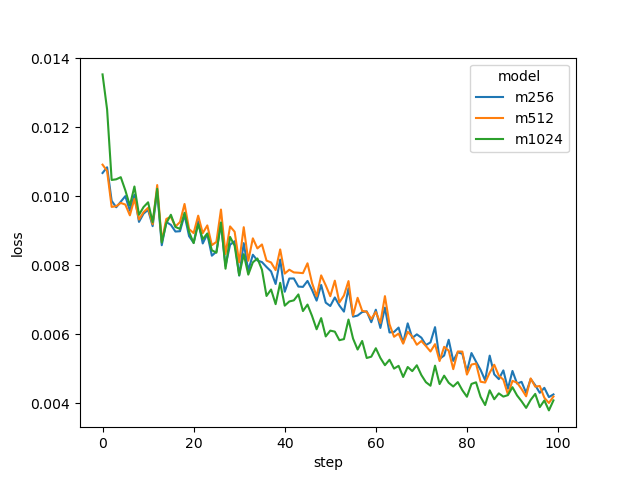

In [12]:
from IPython.display import Image
Image("/mnt/home/wkoh1/example/loss_curve.png")

# Running individual scaden commands

If we don't want to run all 5 steps of the pipeline, we should add one or more of the following flags:
- `-simulate`
- `-process`
- `-train`
- `-predict`
- `-evaluate`

Run the program the same way, e.g.:

`python main.py -load params_predict.yaml` 


params_predict.yaml:
```
predict: True
pred: ~/example/testfile.tsv
model_dir: ~/example/model/
prediction_outname: ~/example/test_predictions.txt
prediction_scaling: None
```

Note: `scaden merge` and `scaden example` are not available.

## Required parameters for each step

These args should be provided if using individual commands.

Simulate
- `out`: Directory to store output files in.
- `data`: Path to scRNA-seq dataset(s)

Process
- `pred`: Bulk data file that we want to perform deconvolution on.
- `training_data`: Training dataset to be processed, generated by the simulate step.
- `processed_path`: Name of the file that the processed data will be saved to. Must end with .h5ad

Train
- `processed_path`: Name of file containing the data that will be used for training.
- `model_dir`: Path to store trained model.

Predict
- `pred`: Bulk data file that we want to perform deconvolution on.
- `model_dir`: Path to trained model.
